In [1]:
import xarray as xr
import xesmf as xa
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
forestfile = "/home/glemieux/Repos/fates/tools/landuse/tests/resources/CLM5_current_luhforest_deg025.nc"
staticfile = "/home/glemieux/Repos/fates/tools/landuse/tests/resources/staticData_quarterdeg.nc"
otherfile = "/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc"
surffile = "/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc"

In [3]:
ds_static = xr.open_dataset(staticfile)
ds_forest = xr.open_dataset(forestfile)
ds_other = xr.open_dataset(otherfile)
ds_surf = xr.open_dataset(surffile)

In [26]:
temp = ds_forest.lon * 0.25 - 180. + 1./8.
(temp == ds_forest.LON).all()

<xarray.DataArray ()>
array(True)

In [28]:
ds_forest['lat'] = ds_forest.lat * 0.25 - 90. + 1./8.
ds_other['lat']  = ds_other.lat * 0.25 - 90. + 1./8.

ds_forest['lon'] = ds_forest.lon * 0.25 - 180. + 1./8.
ds_other['lon']  = ds_other.lon * 0.25 - 180. + 1./8.

In [30]:
fstnf = ds_static.fstnf.astype('float64')
icwtr = ds_static.icwtr.astype('float64')
# fstnf = ds_static.fstnf
# icwtr = ds_static.icwtr

In [31]:
mask_static = (1.-icwtr) / (1.-icwtr)
mask_non_forest = (1. - fstnf)

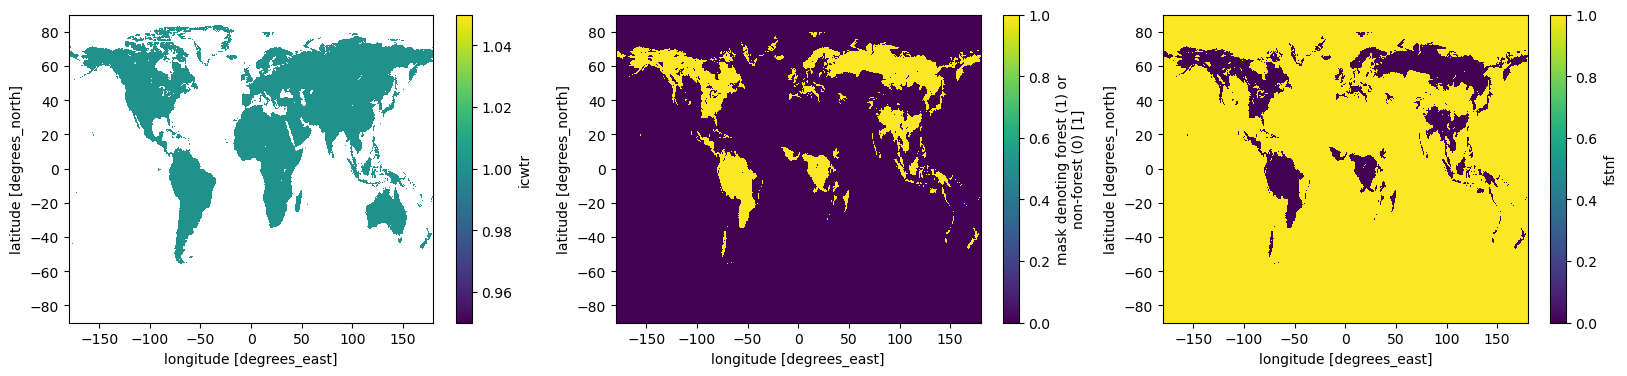

In [32]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
mask_static.plot(ax=ax1)
fstnf.plot(ax=ax2)
mask_non_forest.plot(ax=ax3)

In [33]:
pct_nat_pft_forest = ds_forest.PCT_NAT_PFT.astype('float64').isel(natpft=slice(1,None))
# pct_nat_pft_forest = ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None))
pct_nat_pft_forest = pct_nat_pft_forest / pct_nat_pft_forest.sum(dim='natpft')
# pct_nat_pft_forest_new = ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None)) / ds_forest.PCT_NAT_PFT.isel(natpft=slice(1,None)).sum(dim='natpft') * 100. * landoceanmask

pct_nat_pft_other = ds_other.PCT_NAT_PFT.astype('float64').isel(natpft=slice(1,None))
# pct_nat_pft_other = ds_other.PCT_NAT_PFT.isel(natpft=slice(1,None))
pct_nat_pft_other = pct_nat_pft_other / pct_nat_pft_other.sum(dim='natpft')

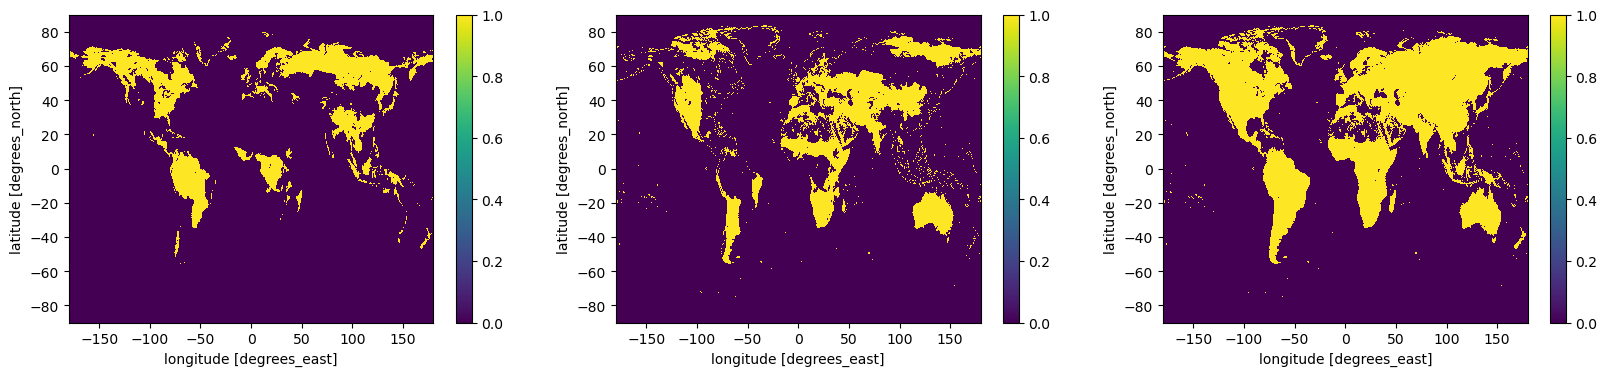

In [34]:
pripct = fstnf * pct_nat_pft_forest
secpct = mask_non_forest * pct_nat_pft_other
prisecpct = pripct + secpct
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
pripct.sum(dim='natpft').plot(ax=ax1)
secpct.sum(dim='natpft').plot(ax=ax2)
prisecpct.sum(dim='natpft').plot(ax=ax3)

/tmp/ipykernel_436650/1330115250.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


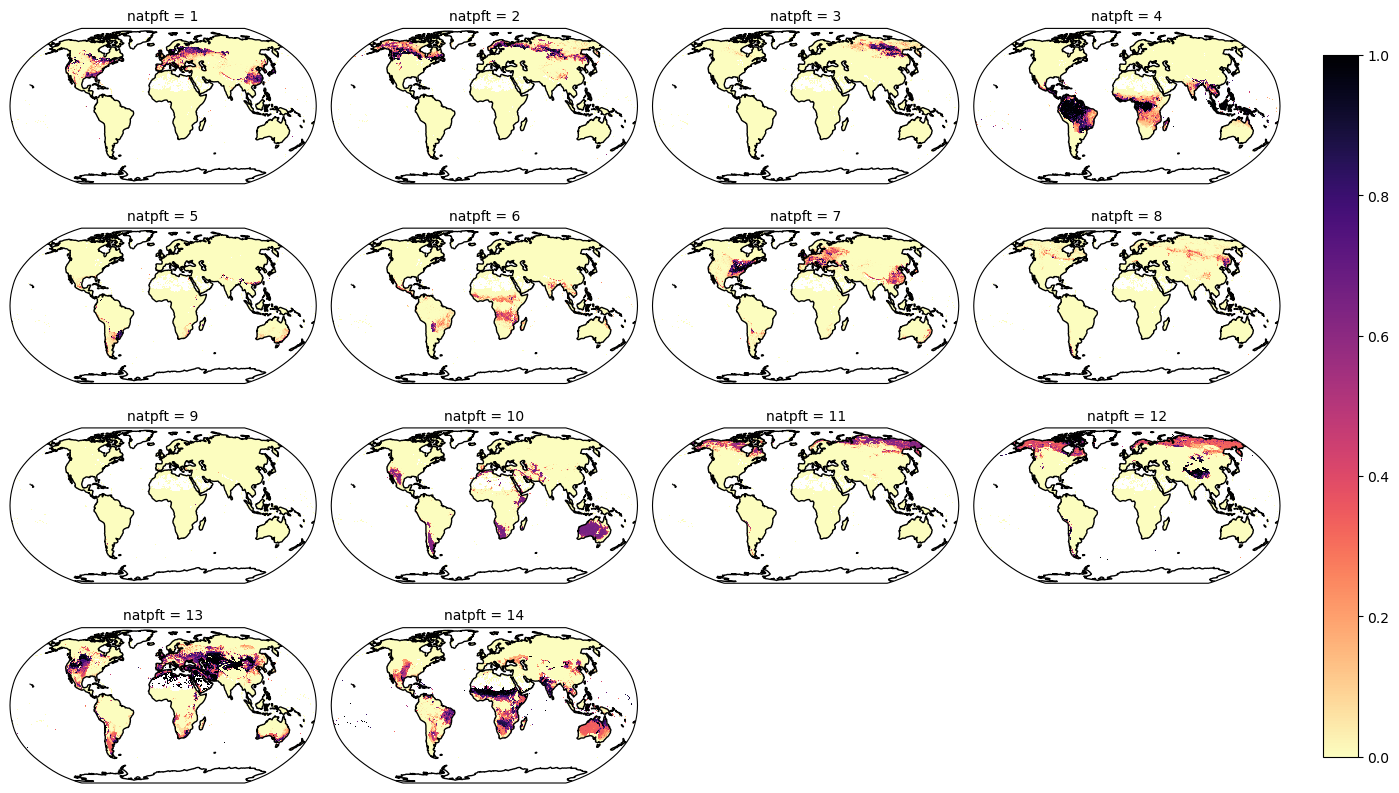

In [12]:
# Copied from Charlie's notebook
fg = prisecpct.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap='magma_r', 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

for ax in fg.axes.flat:
    ax.coastlines() 

# color bar
fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
plt.subplots_adjust(hspace=-0.65)

In [46]:
ds_percent = xr.Dataset()
ds_percent = ds_percent.merge(prisecpct.to_dataset(name='primary'))
ds_percent = ds_percent.merge(ds_forest.LAT.to_dataset(name='LAT'))
ds_percent = ds_percent.merge(ds_forest.LON.to_dataset(name='LON'))

In [47]:
ds_percent

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 720, natpft: 14)
Coordinates:
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * natpft   (natpft) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14
Data variables:
    primary  (lat, lon, natpft) float64 nan nan nan nan nan ... nan nan nan nan
    LAT      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
    LON      (lon) float32 ...

In [63]:
regrid_target = xr.open_dataset("/home/glemieux/Data/luh2/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc")

In [64]:
regrid_target = regrid_target.rename_dims(dims_dict={'lsmlat':'lat','lsmlon':'lon'})
regrid_target['lon'] = regrid_target.LONGXY.isel(lat=0)
regrid_target['lat'] = regrid_target.LATIXY.isel(lon=0)

ValueError: Dimensions {'lat'} do not exist. Expected one or more of ('lsmlat', 'lsmlon')

In [ ]:
regrid_target

In [62]:
regridder = xa.Regridder(ds_percent, regrid_target, "conservative")

/home/glemieux/local/conda/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [65]:
ds_netcdf = xr.open_dataset("/home/glemieux/Repos/fates/tools/landuse/src/landusepft/fates_landuse_pft_map.nc")

In [66]:
ds_netcdf

<xarray.Dataset>
Dimensions:          (lat: 46, lon: 72, natpft: 14)
Coordinates:
  * natpft           (natpft) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * lon              (lon) float64 0.0 5.0 10.0 15.0 ... 340.0 345.0 350.0 355.0
  * lat              (lat) float64 -90.0 -86.0 -82.0 -78.0 ... 82.0 86.0 90.0
Data variables:
    bareground       (lat, lon) float64 ...
    current_surface  (natpft, lat, lon) float64 ...
    primary          (natpft, lat, lon) float64 ...
    pasture          (natpft, lat, lon) float64 ...
    range            (natpft, lat, lon) float64 ...
    secondary        (natpft, lat, lon) float64 ...
Attributes:
    regrid_method:  conservative

In [74]:
def plotnatpft(variable):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap='magma_r', 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Current surface

/tmp/ipykernel_443734/1004337997.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


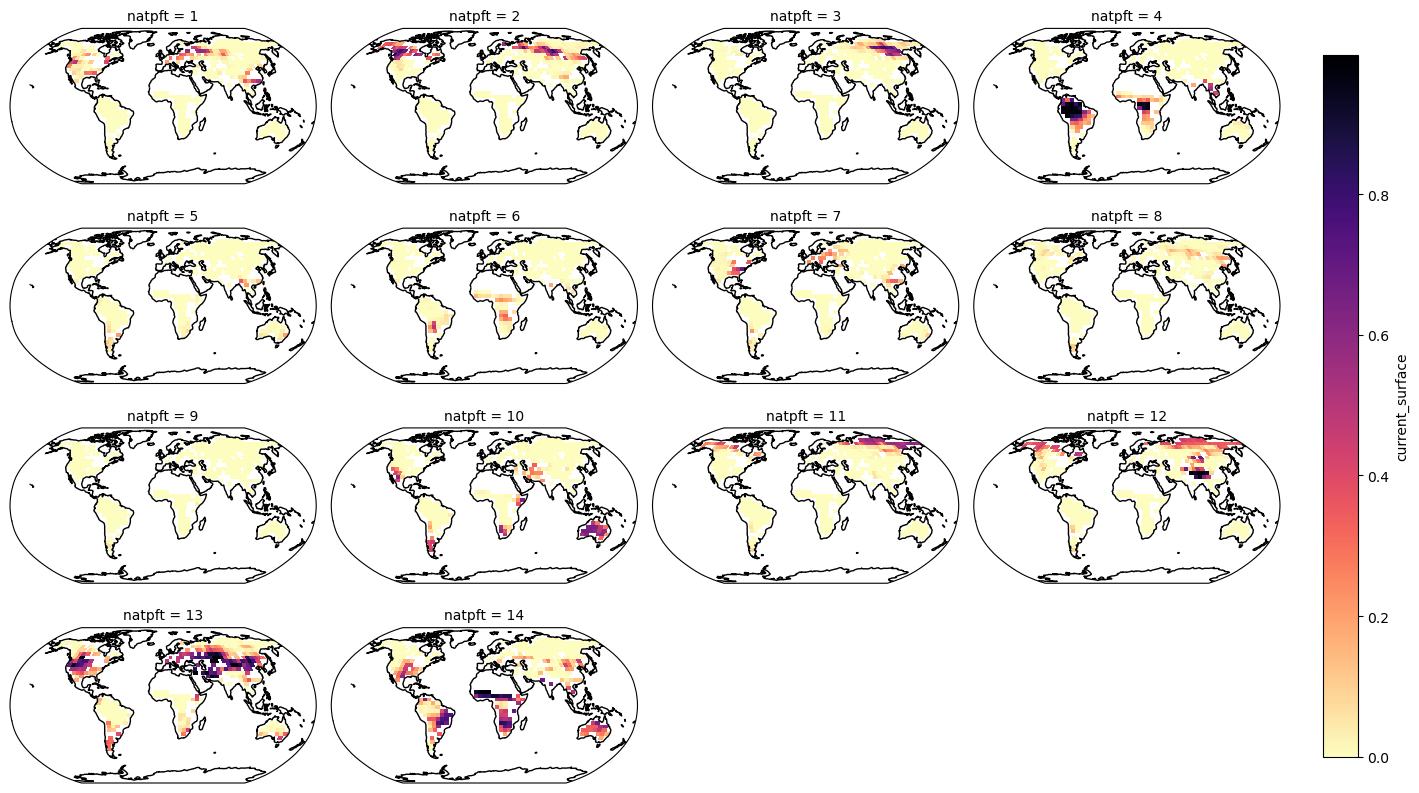

In [75]:
plotnatpft(ds_netcdf.current_surface)

/tmp/ipykernel_443734/1004337997.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


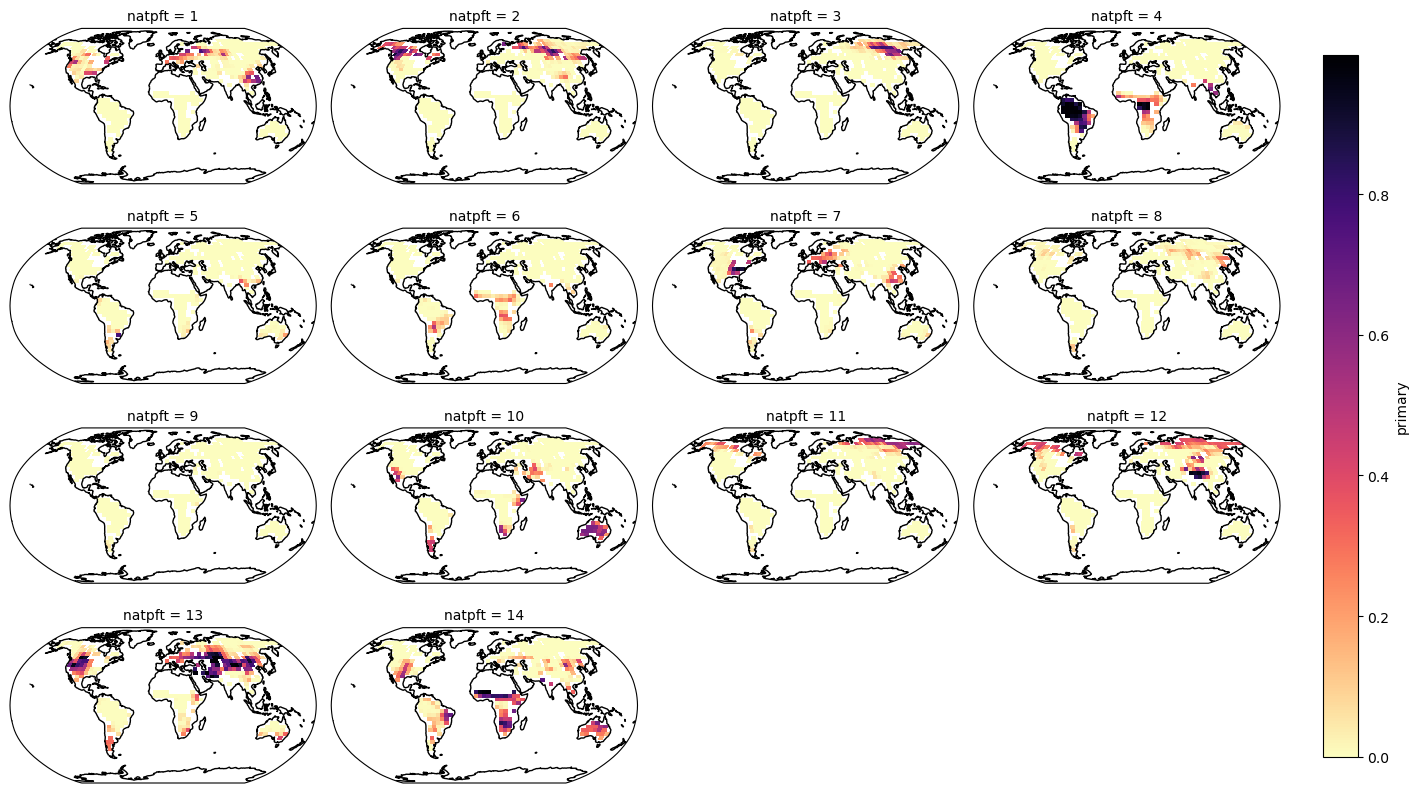

In [76]:
plotnatpft(ds_netcdf.primary)